In [3]:
library(parallel)
detectCores(logical = FALSE)


[1] 32

In [4]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(scMEGA))
suppressMessages(library(Nebulosa))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))
suppressMessages(library(GenomeInfoDb))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(JASPAR2020))
suppressMessages(library(TFBSTools))
suppressMessages(library(igraph))
suppressMessages(library(ggraph))
suppressMessages(library(MOJITOO))

Warning message:
“package ‘ArchR’ was built under R version 4.3.3”
Warning message:
“package ‘gtools’ was built under R version 4.3.3”
Warning message:
“package ‘gtable’ was built under R version 4.3.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘magrittr’ was built under R version 4.3.3”
Warning message:
“package ‘plyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.3.3”
Warning message:
“package ‘rhdf5’ was built under R version 4.3.3”
Warning message:
“package ‘scMEGA’ was built under R version 4.3.3”
Warning message:
“package ‘patchwork’ was built under R version 4.3.2”
Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg38’ was built under R version 4.3.3”
Warning message:
“package ‘EnsDb.Hsapiens.v86’ was built under R version 4.3.3”
Warning m

In [116]:
# Check session information
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.4 (Seafoam Ocelot)

Matrix products: default
BLAS/LAPACK: /mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/.conda/envs/R1/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
 [1] stats4    grid      parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] peakRAM_1.0.2                     circlize_0.4.16                  
 [3] ComplexHeatmap_2.18.0             hdf5r_1.3.11        

In [5]:
library(pryr)
mem_used()
system2("grep", "MemTotal /proc/meminfo", stdout = TRUE)

Warning message:
"package 'pryr' was built under R version 4.3.3"

Attaching package: 'pryr'


The following object is masked from 'package:igraph':

    compose


The following object is masked from 'package:dplyr':

    where


The following object is masked from 'package:data.table':

    address




1.37 GB

[1] "MemTotal:       2112594368 kB"

In [6]:
inputdata.10x <- Read10X_h5("/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/PBMC/filtered_feature_bc_matrix.h5")

Warning message:
"package 'bench' was built under R version 4.3.3"
Genome matrix has multiple modalities, returning a list of matrices for this genome



In [8]:
library(hdf5r)


Attaching package: 'hdf5r'


The following object is masked from 'package:rtracklayer':

    values


The following object is masked from 'package:rhdf5':

    h5version


The following object is masked from 'package:SummarizedExperiment':

    values


The following object is masked from 'package:GenomicRanges':

    values


The following object is masked from 'package:S4Vectors':

    values




In [9]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/models/R-scMEGA"

In [10]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [11]:
## Genome matrix has multiple modalities, returning a list of matrices for this genome
# extract RNA and ATAC data
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

In [12]:
# filter peaks by chromosome
atac_counts <- atac_counts[grep("chr", rownames(atac_counts)), ]

An object of class Seurat 
36601 features across 11426 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data

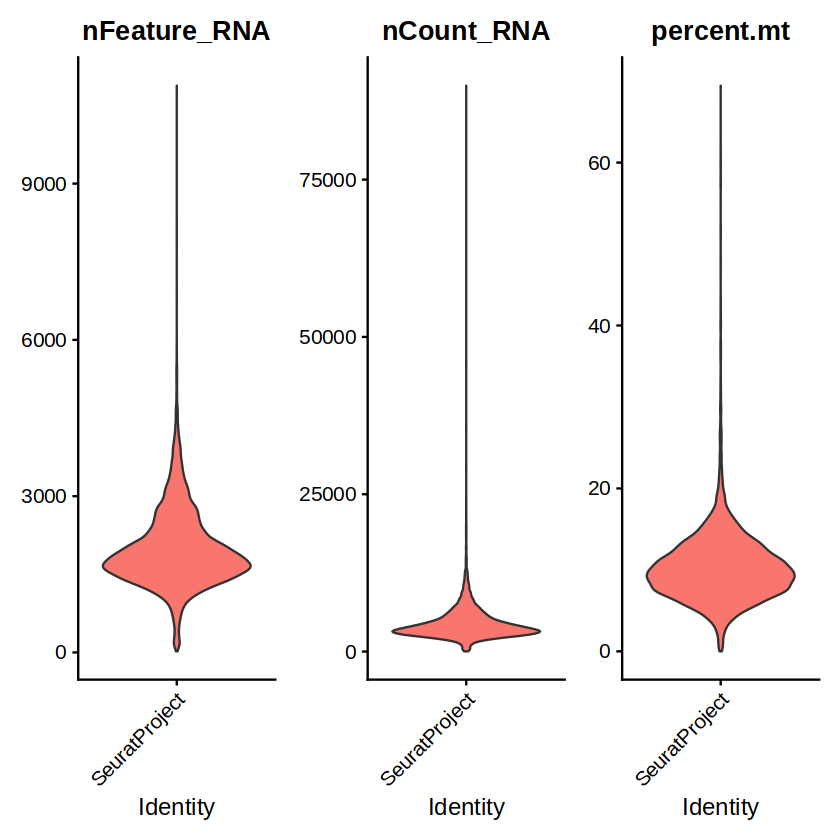

In [13]:
#Next, we create a Seurat object and filter low-quality cells from the scRNA-seq data.
obj.rna <- CreateSeuratObject(counts = rna_counts)
obj.rna <- NormalizeData(obj.rna, verbose = FALSE)
obj.rna[["percent.mt"]] <- PercentageFeatureSet(obj.rna, pattern = "^MT-")
# Visualize QC metrics as a violin plot
vln1<-VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)
vln1
#ggsave(filename='plot1.png',plot=vln1,width=16,height=12,dpi=600)
obj.rna <- subset(obj.rna, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 20 & nCount_RNA < 13000)

obj.rna

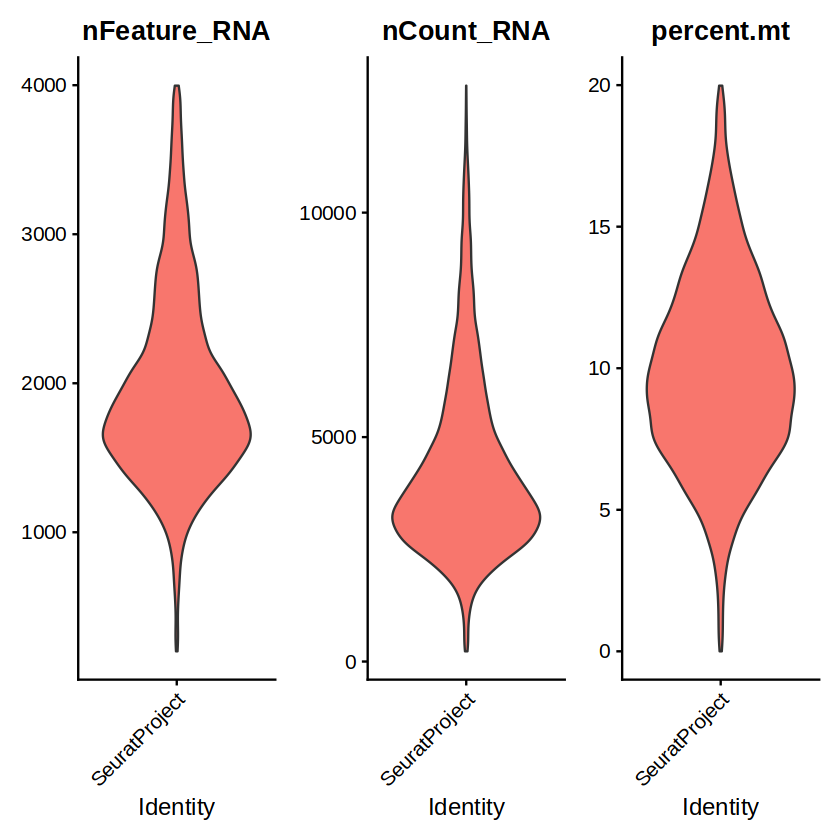

In [14]:
vln2<-VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)
vln2
#ggsave(filename='plot2.png',plot=vln2,width=16,height=12,dpi=600)

In [15]:
# create seurat object
chrom_assay <- CreateChromatinAssay(
  counts = atac_counts,
  sep = c(":", "-"),
  min.cells = 1,
  genome = 'hg38',
  fragments = './PBMC/atac_fragments.tsv.gz'
)

Computing hash



In [16]:
obj.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "ATAC")

In [17]:
# extract gene annotations from EnsDb
#annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86, 
  #                                 verbose = FALSE)

In [18]:
# change to UCSC style since the data was mapped to hg38

#seqlevelsStyle(annotations) <- 'UCSC'


In [19]:
annotations<-readRDS("./models/R-scMEGA/annotations.rds")
mem_used()

5.55 GB

In [20]:
# add the gene information to the object
Annotation(obj.atac) <- annotations

In [21]:
annotations

GRanges object with 3021151 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 276322-276394      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 276324-276394      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 276353-276394      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 281055-281121      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 281192-281684      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739     chrM     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789     chrM   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851     chrM     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899     chrM     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



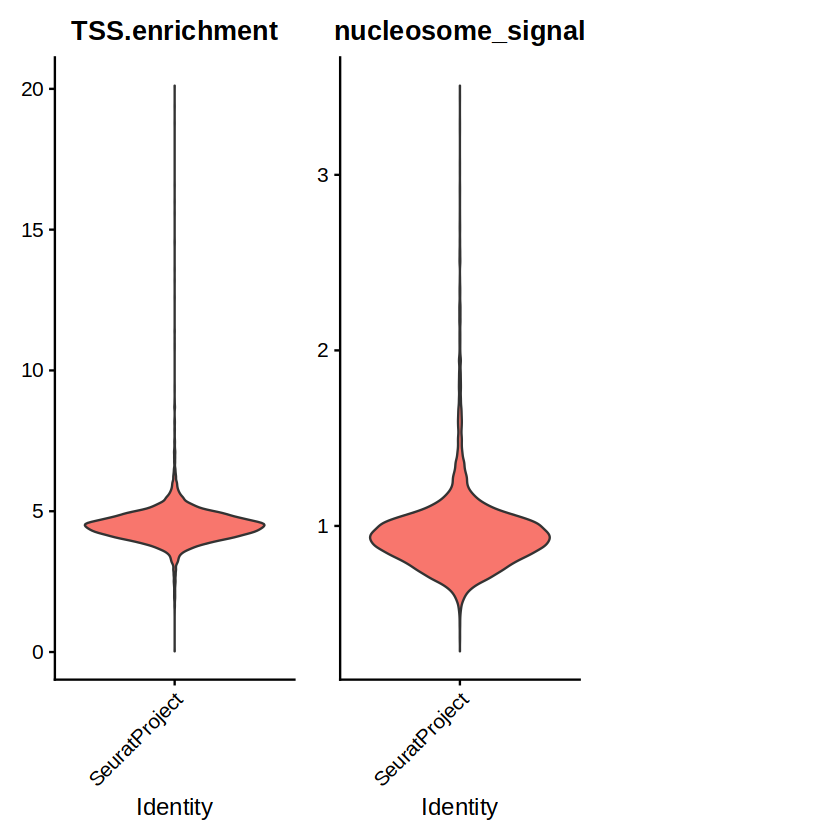

In [22]:
obj.atac <- TSSEnrichment(obj.atac, fast = FALSE)
obj.atac <- NucleosomeSignal(obj.atac)



VlnPlot(
  obj.atac,
  features = c( "TSS.enrichment", "nucleosome_signal"),
  pt.size = 0,
  ncol = 3
)



In [23]:
obj.atac

An object of class Seurat 
107829 features across 11909 samples within 1 assay 
Active assay: ATAC (107829 features, 0 variable features)
 2 layers present: counts, data

In [24]:
# Filter low-quality cells
obj.atac <- subset(
  x = obj.atac,
  subset =
           nucleosome_signal < 4 & 
           TSS.enrichment > 2
)

In [25]:
obj.atac

An object of class Seurat 
107829 features across 11890 samples within 1 assay 
Active assay: ATAC (107829 features, 0 variable features)
 2 layers present: counts, data

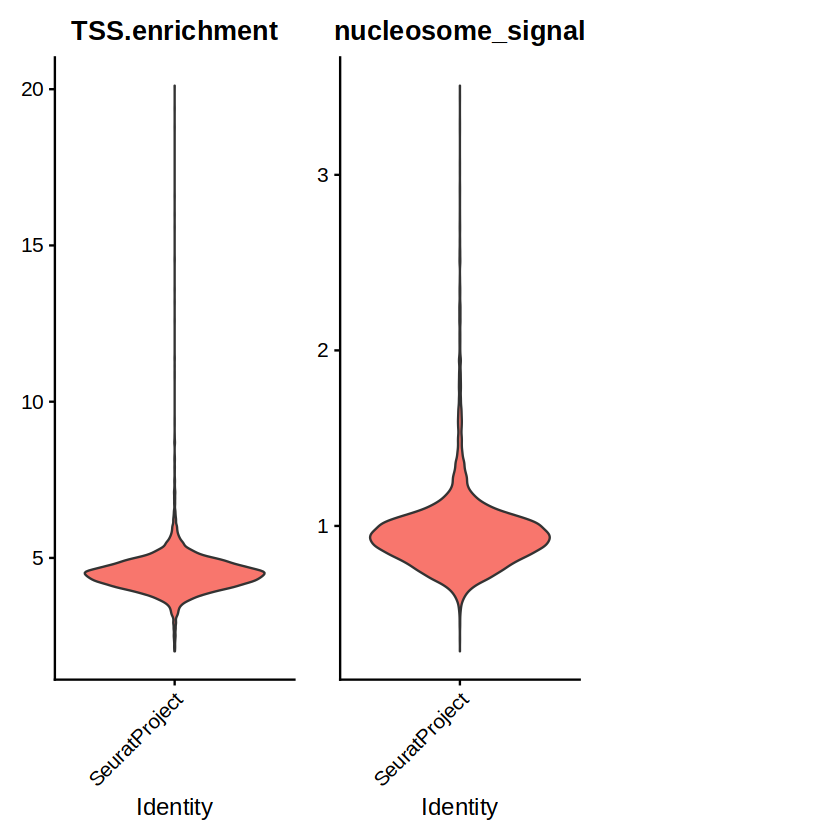

In [26]:
VlnPlot(
  obj.atac,
  features = c( "TSS.enrichment", "nucleosome_signal"),
  pt.size = 0,
  ncol = 3
)


In [27]:
cell.sel <- intersect(colnames(obj.rna), colnames(obj.atac))

In [28]:
obj.rna <- subset(obj.rna, cells = cell.sel)
obj.atac <- subset(obj.atac, cells = cell.sel)

In [29]:
obj.atac

An object of class Seurat 
107829 features across 11414 samples within 1 assay 
Active assay: ATAC (107829 features, 0 variable features)
 2 layers present: counts, data

In [30]:
# normalization followed by dimensionality reduction
obj.rna <- obj.rna %>%
  NormalizeData(verbose=FALSE) %>%
  FindVariableFeatures(nfeatures=3000, verbose=F) %>%
  ScaleData() %>%
  RunPCA(verbose = FALSE) %>%
  RunUMAP(dims = 1:30, verbose = FALSE)

obj.atac <- obj.atac %>%
  RunTFIDF() %>%
  FindTopFeatures() %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30, verbose = FALSE)

Centering and scaling data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'



In [31]:
obj.rna

An object of class Seurat 
36601 features across 11414 samples within 1 assay 
Active assay: RNA (36601 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

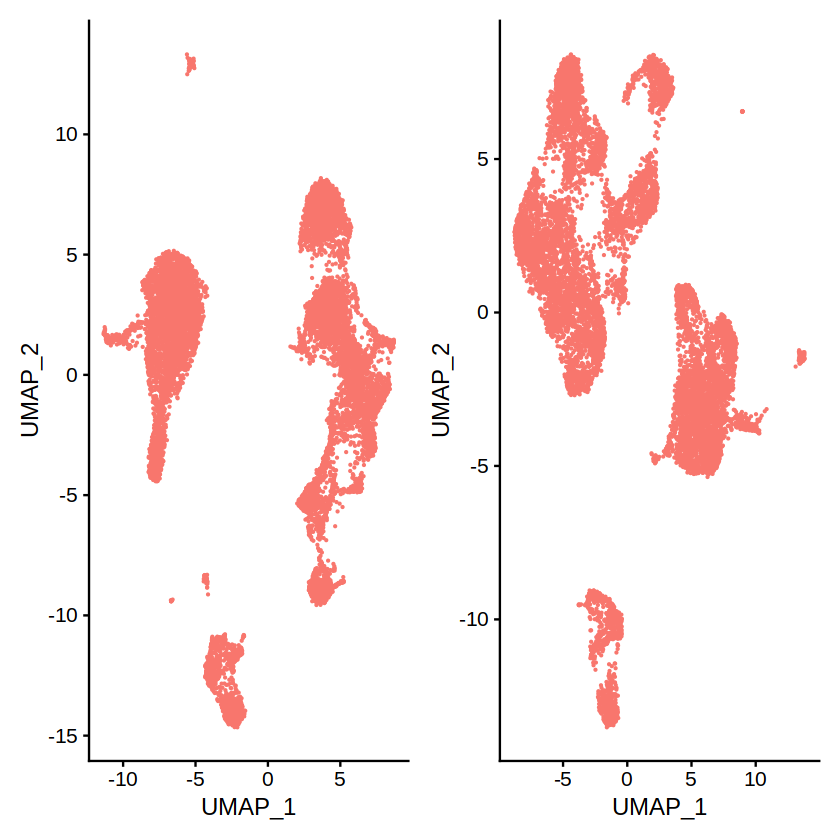

In [32]:
p1 <- DimPlot(obj.rna) + NoLegend()
p2 <- DimPlot(obj.atac) + NoLegend()

p1 + p2

#ggsave(filename='plot3.png',plot=p1+p2,width=16,height=8,dpi=600)

In [33]:
setwd("./models/R-scMEGA")

# Cell type annotation

In [34]:
reference <- readRDS("seurat.rds")
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [35]:
reference[["RNA"]] <- CreateAssayObject(counts = reference[["RNA"]]@counts)
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [36]:
# we only keep cells with annotated cell type
reference <- subset(reference, subset = celltype != "NA")

Warning message:
"Removing 1877 cells missing data for vars requested"


In [37]:
reference <- reference %>%
    NormalizeData(verbose=FALSE) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData() %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)
# run sctransform


Centering and scaling data matrix

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Centering and scaling data matrix

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'



# A tibble: 1 × 13
  expression      min median `itr/sec` mem_alloc `gc/sec` n_itr  n_gc total_time
  <bch:expr>    <bch> <bch:>     <dbl> <bch:byt>    <dbl> <int> <dbl>   <bch:tm>
1 reference <-… 23.1s  23.1s    0.0432     2.4GB        0     1     0      23.1s
# ℹ 4 more variables: result <list>, memory <list>, time <list>, gc <list>


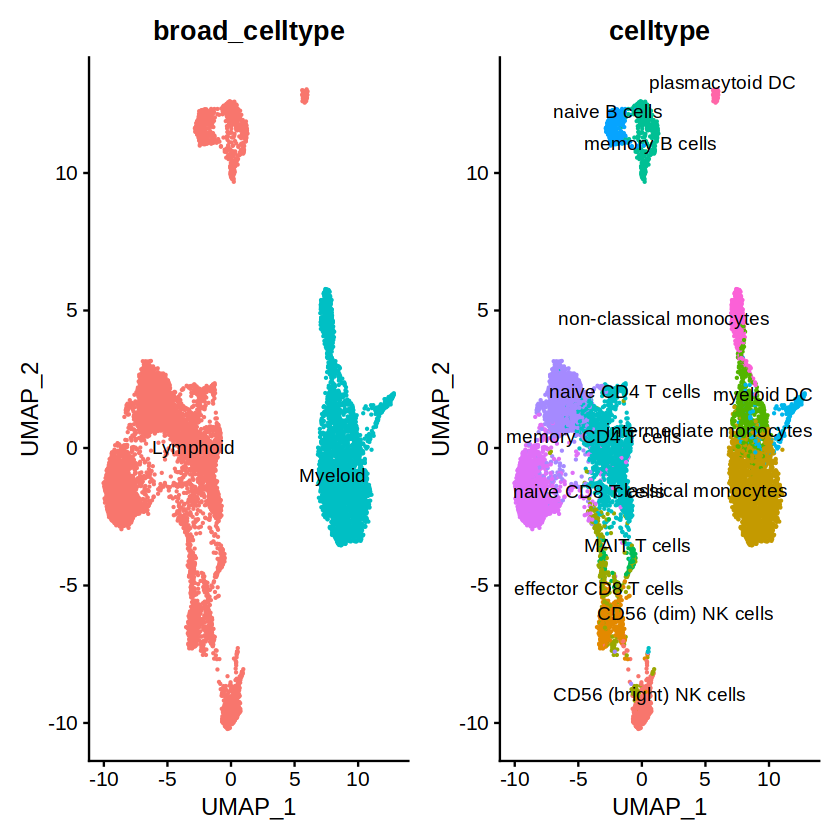

In [39]:
p1 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "broad_celltype") + NoLegend()

p2 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "celltype") + NoLegend()

p1 + p2

#ggsave(filename='umap.png',plot=p1+p2,width=16,height=8,dpi=600)

In [40]:
    transfer_anchors <- FindTransferAnchors(
  reference = reference,
  query = obj.rna,
  reference.reduction = "pca",
  dims = 1:30
)


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 27444 anchors

Filtering anchors

	Retained 18538 anchors



In [41]:
predictions <- TransferData(
  anchorset = transfer_anchors, 
  refdata = reference$celltype,
  weight.reduction = obj.rna[['pca']],
  dims = 1:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [42]:
predictions 

,predicted.id,prediction.score.naive.CD4.T.cells,prediction.score.memory.CD4.T.cells,prediction.score.non.classical.monocytes,prediction.score.naive.CD8.T.cells,prediction.score.CD56..bright..NK.cells,prediction.score.classical.monocytes,prediction.score.effector.CD8.T.cells,prediction.score.myeloid.DC,prediction.score.intermediate.monocytes,prediction.score.memory.B.cells,prediction.score.MAIT.T.cells,prediction.score.CD56..dim..NK.cells,prediction.score.naive.B.cells,prediction.score.plasmacytoid.DC,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACAGCCAAGGAATC-1,naive CD4 T cells,0.7343529,0.000000000,0,0.26564714,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.7343529
AAACAGCCAATCCCTT-1,memory CD4 T cells,0.0000000,0.957209032,0,0.02990120,0.0000000,0.000000000,0.012889766,0.0000000,0.00000000,0,0,0.00000000,0,0,0.9572090
AAACAGCCAATGCGCT-1,naive CD4 T cells,0.9932456,0.003754124,0,0.00300025,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.9932456
AAACAGCCACACTAAT-1,naive CD8 T cells,0.2161841,0.000000000,0,0.78381593,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.7838159
AAACAGCCACCAACCG-1,naive CD8 T cells,0.1122483,0.000000000,0,0.88775172,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.8877517
AAACAGCCAGGATAAC-1,naive CD4 T cells,1.0000000,0.000000000,0,0.00000000,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,1.0000000
AAACAGCCAGTAGGTG-1,naive CD8 T cells,0.2433354,0.000000000,0,0.75501041,0.0000000,0.000000000,0.001654171,0.0000000,0.00000000,0,0,0.00000000,0,0,0.7550104
AAACAGCCAGTTTACG-1,memory CD4 T cells,0.0000000,1.000000000,0,0.00000000,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,1.0000000
AAACAGCCATCCAGGT-1,non-classical monocytes,0.0000000,0.000000000,1,0.00000000,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,1.0000000


In [43]:
obj.rna <- AddMetaData(
  object = obj.rna,
  metadata = predictions
)

obj.atac <- AddMetaData(
  object = obj.atac,
  metadata = predictions
)

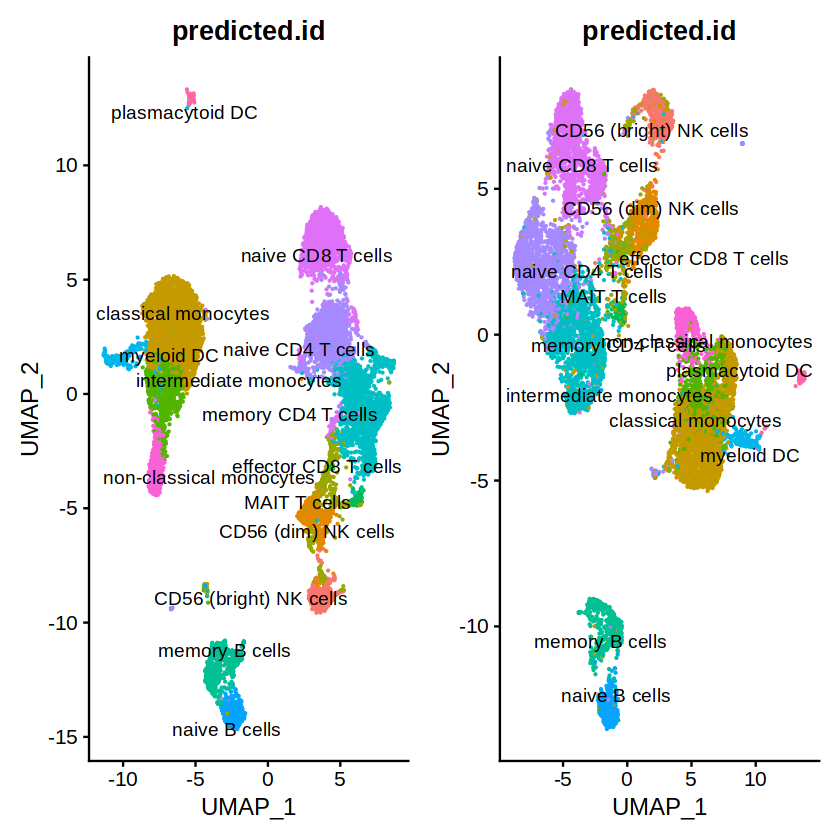

In [44]:
p1 <- DimPlot(obj.rna, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p2 <- DimPlot(obj.atac, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p1 + p2
#ggsave(filename='plot5.png',plot=p1+p2,width=16,height=8,dpi=600)

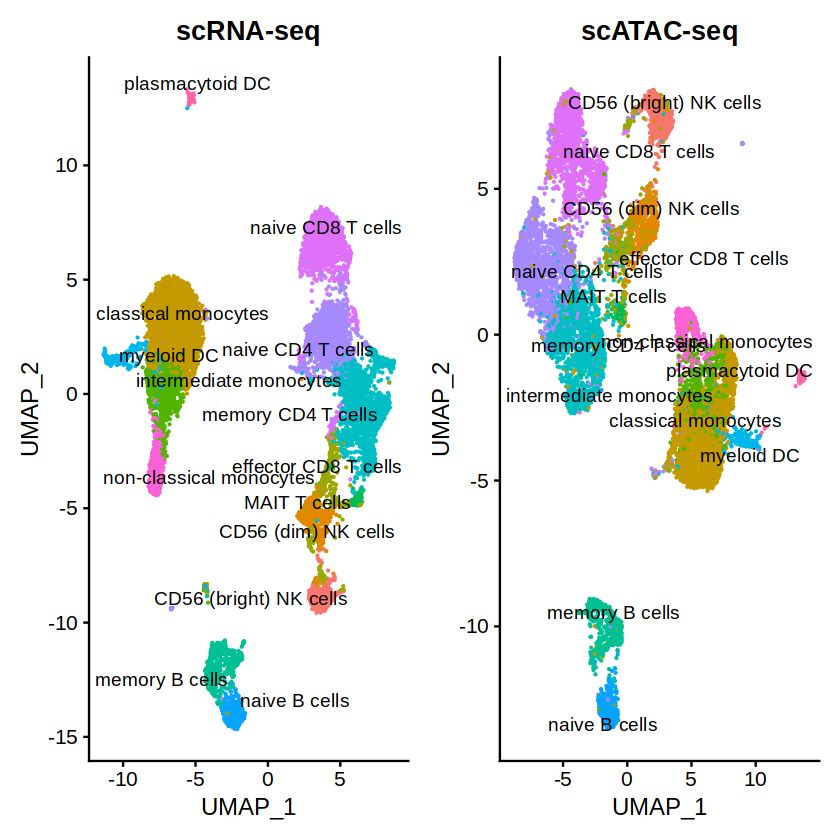

In [45]:
p1 <- DimPlot(obj.rna, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend() + ggtitle('scRNA-seq')

p2 <- DimPlot(obj.atac, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend() +  ggtitle('scATAC-seq')
p1+p2
#ggsave(filename='plot5.png',plot=p1+p2,width=16,height=8,dpi=600)

# Integrating multimodal single-cell data using MOJITOO

In [46]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [47]:
meta.data <- obj.rna@meta.data %>%
    as.data.frame()



In [48]:
meta.data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,predicted.id,prediction.score.naive.CD4.T.cells,prediction.score.memory.CD4.T.cells,prediction.score.non.classical.monocytes,prediction.score.naive.CD8.T.cells,prediction.score.CD56..bright..NK.cells,prediction.score.classical.monocytes,prediction.score.effector.CD8.T.cells,prediction.score.myeloid.DC,prediction.score.intermediate.monocytes,prediction.score.memory.B.cells,prediction.score.MAIT.T.cells,prediction.score.CD56..dim..NK.cells,prediction.score.naive.B.cells,prediction.score.plasmacytoid.DC,prediction.score.max
,<fct>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACAGCCAAGGAATC-1,SeuratProject,8380,3308,7.4701671,naive CD4 T cells,0.7343529,0.000000000,0,0.26564714,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.7343529
AAACAGCCAATCCCTT-1,SeuratProject,3771,1896,10.5277115,memory CD4 T cells,0.0000000,0.957209032,0,0.02990120,0.0000000,0.000000000,0.012889766,0.0000000,0.00000000,0,0,0.00000000,0,0,0.9572090
AAACAGCCAATGCGCT-1,SeuratProject,6876,2904,6.4572426,naive CD4 T cells,0.9932456,0.003754124,0,0.00300025,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.9932456
AAACAGCCACACTAAT-1,SeuratProject,1733,846,18.0034622,naive CD8 T cells,0.2161841,0.000000000,0,0.78381593,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.7838159
AAACAGCCACCAACCG-1,SeuratProject,5415,2282,6.5004617,naive CD8 T cells,0.1122483,0.000000000,0,0.88775172,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,0.8877517
AAACAGCCAGGATAAC-1,SeuratProject,2759,1353,6.9227981,naive CD4 T cells,1.0000000,0.000000000,0,0.00000000,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,1.0000000
AAACAGCCAGTAGGTG-1,SeuratProject,7614,3061,6.8951931,naive CD8 T cells,0.2433354,0.000000000,0,0.75501041,0.0000000,0.000000000,0.001654171,0.0000000,0.00000000,0,0,0.00000000,0,0,0.7550104
AAACAGCCAGTTTACG-1,SeuratProject,3633,1691,4.1838701,memory CD4 T cells,0.0000000,1.000000000,0,0.00000000,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,1.0000000
AAACAGCCATCCAGGT-1,SeuratProject,7782,3028,11.0125932,non-classical monocytes,0.0000000,0.000000000,1,0.00000000,0.0000000,0.000000000,0.000000000,0.0000000,0.00000000,0,0,0.00000000,0,0,1.0000000


In [49]:
# create a Seurat object containing the RNA adata
pbmc <- CreateSeuratObject(
  counts = obj.rna@assays$RNA@counts,
  assay = "RNA",
    meta.data = meta.data
)



In [52]:
# create ATAC assay and add it to the object
pbmc[["ATAC"]] <- CreateChromatinAssay(
  counts = obj.atac@assays$ATAC@counts,
  sep = c(":", "-"),
    min.cells = 1,
    genome = 'hg38',
    fragments = './PBMC/atac_fragments.tsv.gz'
)

Computing hash



In [53]:
## RNA pre-processing and PCA dimension reduction
DefaultAssay(pbmc) <- "RNA"

pbmc <- pbmc %>%
    NormalizeData(verbose=F) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData(verbose=F) %>%
    RunPCA(npcs=50, reduction.name="RNA_PCA", verbose=F)

In [54]:
## ATAC pre-processing and LSI dimension reduction
DefaultAssay(pbmc) <- "ATAC"

pbmc <- pbmc %>%
    RunTFIDF(verbose=F) %>%
    FindTopFeatures(min.cutoff = 'q0', verbose=F) %>%
    RunSVD(verbose=F)

# MOJITOO

In [56]:

pbmc <- mojitoo(
     object = pbmc,
     reduction.list = list("RNA_PCA", "lsi"),
     dims.list = list(1:50, 2:50), ## exclude 1st dimension of LSI
     reduction.name = 'MOJITOO',
     assay = "RNA"
)

processing RNA_PCA

adding lsi

1 round cc 45

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from MOJITOO to MOJITOO_"


In [57]:
DefaultAssay(pbmc) <- "RNA"
embedd <- Embeddings(pbmc[["MOJITOO"]])
pbmc <- RunUMAP(pbmc, 
                reduction="MOJITOO", 
                reduction.name="MOJITOO_UMAP", 
                dims=1:ncol(embedd), verbose=F)

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'



In [58]:
p<-DimPlot(pbmc, group.by = "predicted.id", 
        shuffle = TRUE, label = TRUE, reduction = "MOJITOO_UMAP") + NoLegend()


#ggsave(filename='plot6.png',plot=p,width=16,height=16,dpi=600)

# Trajectory analysis

In [58]:
##Next, we inferred the trajectory from naive CD4 T cells to memory CD4 T cells to characterize CD4+ T cell activation

In [59]:
pbmc <- AddTrajectory(object = pbmc, 
                      trajectory = c("naive CD4 T cells", 
                                     "memory CD4 T cells"),
                      group.by = "predicted.id", 
                          reduction = "MOJITOO_UMAP",
                          dims = 1:2, 
                          use.all = FALSE)



In [60]:
# we only plot the cells that are in this trajectory
pbmc.t.cells <- pbmc[, !is.na(pbmc$Trajectory)]

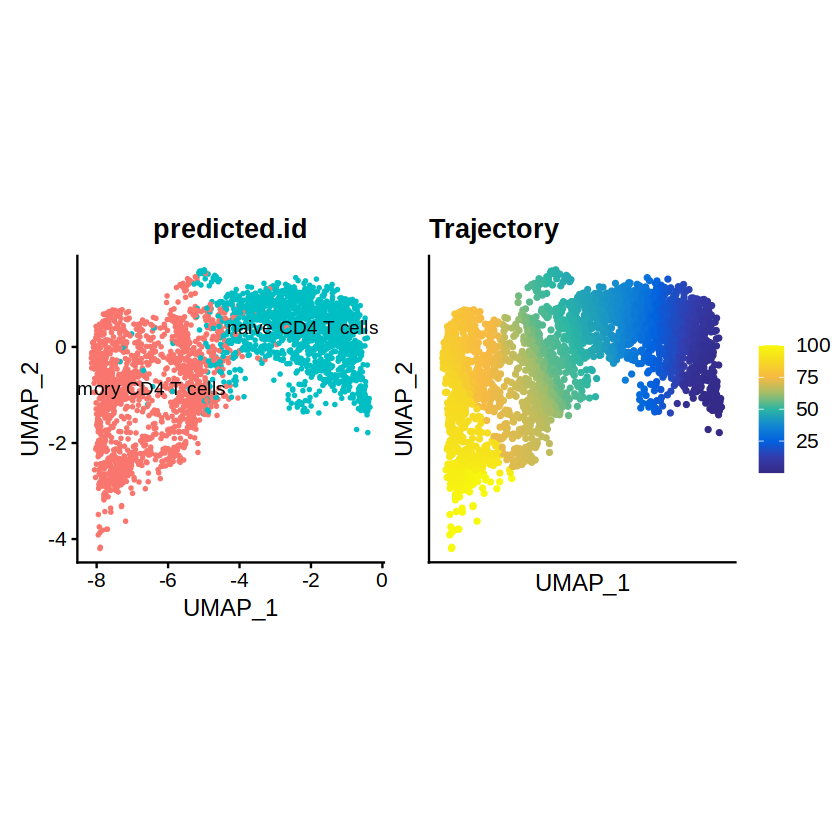

In [61]:
p1 <- DimPlot(object = pbmc.t.cells, 
              group.by = "predicted.id", 
              reduction = "MOJITOO_UMAP",
             label = TRUE) + NoLegend()

p2 <- TrajectoryPlot(object = pbmc.t.cells, 
                    reduction = "MOJITOO_UMAP",
                    continuousSet = "blueYellow",
                    size = 1,
                   addArrow = FALSE)
p1 + p2

#ggsave(filename='plot7.png',plot=p1+p2,width=16,height=8,dpi=600)

In [62]:
pbmc.t.cells 

An object of class Seurat 
144412 features across 3077 samples within 2 assays 
Active assay: RNA (36601 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 4 dimensional reductions calculated: RNA_PCA, lsi, MOJITOO, MOJITOO_UMAP

# Performance test

In [108]:
library(peakRAM)

Building motif matrix

Finding motif positions

Creating Motif object

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Find 559 shared features!

Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Linking cis-regulatory elements to genes...

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Filtering network by peak-to-gene links...

Filtering network by TF binding site prediction...

Warning message:
"Using alpha for a discrete

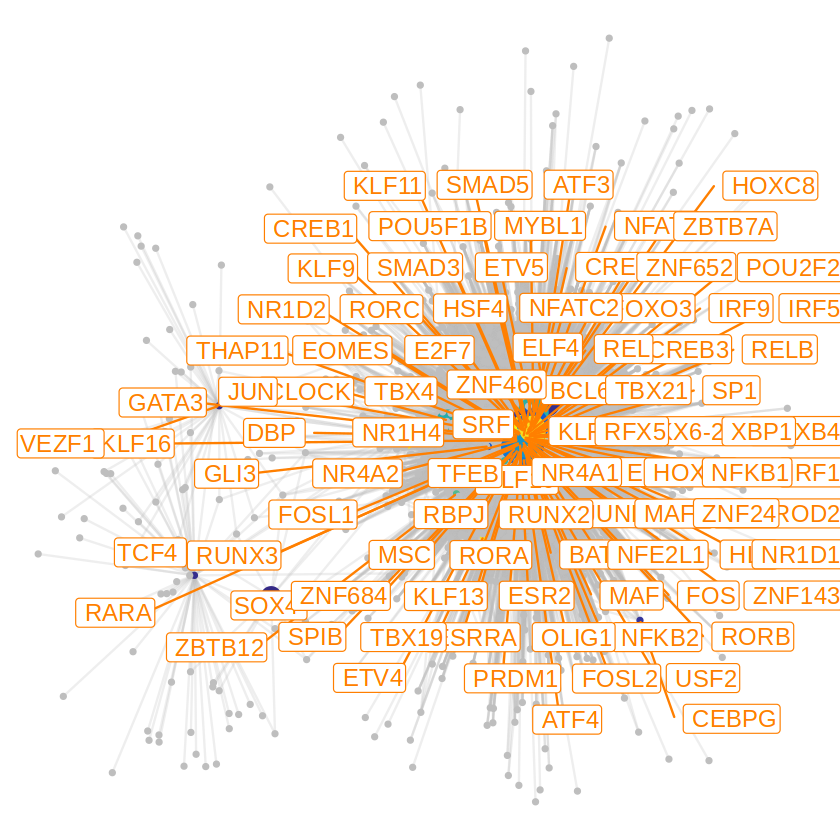

In [111]:
result <- peakRAM({
 pbmc.t.cells <- AddMotifs(object = pbmc.t.cells,genome = BSgenome.Hsapiens.UCSC.hg38,pfm = pfm,assay = "ATAC")
    
   # run chromVAR
 pbmc.t.cells <- RunChromVAR(object = pbmc.t.cells,genome = BSgenome.Hsapiens.UCSC.hg38,assay = "ATAC")
 sel.tfs <- SelectTFs(object = pbmc.t.cells, 
                return.heatmap = TRUE,
                cor.cutoff = 0.4)
 df.cor <- sel.tfs$tfs
# ht <- sel.tfs$heatmap
 
 sel.genes <- SelectGenes(object = pbmc.t.cells,
                  labelTop1 = 0,
                  labelTop2 = 0)

  df.p2g <- sel.genes$p2g
#  ht <- sel.genes$heatmap
  tf.gene.cor <- GetTFGeneCorrelation(object = pbmc.t.cells, 
                                    tf.use = df.cor$tfs, 
                                    gene.use = unique(df.p2g$gene),
                                    tf.assay = "chromvar", 
                                    gene.assay = "RNA",
                                    trajectory.name = "Trajectory")
  #ht <- GRNHeatmap(tf.gene.cor, tf.timepoint = df.cor$time_point)
 motif.matching <- pbmc.t.cells@assays$ATAC@motifs@data
 colnames(motif.matching) <- pbmc.t.cells@assays$ATAC@motifs@motif.names
 motif.matching <- motif.matching[unique(df.p2g$peak), unique(tf.gene.cor$tf)]

 df.grn <- GetGRN(motif.matching = motif.matching, 
                 df.cor = tf.gene.cor, 
                 df.p2g = df.p2g)
    
  # define colors for nodes representing TFs (i.e., regulators)
 df.cor <- df.cor[order(df.cor$time_point), ]
 tfs.timepoint <- df.cor$time_point
 names(tfs.timepoint) <- df.cor$tfs

# plot the graph, here we can highlight some genes
 df.grn2 <- df.grn %>%
    subset(correlation > 0.5) %>%
    select(c(tf, gene, correlation)) %>%
    rename(weights = correlation)

 p <- GRNPlot(df.grn2, 
             tfs.timepoint = tfs.timepoint,
             show.tf.labels = TRUE,
             seed = 42, 
             plot.importance = FALSE,
            min.importance = 2,
            remove.isolated = FALSE)

 print(p)  
    
})

print(result)

# TF and gene selection

## select TF

In [62]:
#To identify potential regulator (i.e., TFs), we first estimate an acitivty score for each TF in each cell. This is done by first performing motif matching and then computing deviation scores using chromVAR

In [63]:
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)



In [65]:

  # add motif information
pbmc.t.cells <- AddMotifs(
  object = pbmc.t.cells,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  pfm = pfm,
    assay = "ATAC"
)


Building motif matrix

Finding motif positions

Creating Motif object



In [66]:
# run chromVAR
pbmc.t.cells <- RunChromVAR(
  object = pbmc.t.cells,
  genome = BSgenome.Hsapiens.UCSC.hg38,
    assay = "ATAC"
)


Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [67]:
pbmc.t.cells 

An object of class Seurat 
145158 features across 3077 samples within 3 assays 
Active assay: RNA (36601 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ATAC, chromvar
 4 dimensional reductions calculated: RNA_PCA, lsi, MOJITOO, MOJITOO_UMAP

In [68]:
sel.tfs <- SelectTFs(object = pbmc.t.cells, 
                 return.heatmap = TRUE,
                cor.cutoff = 0.4)


Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Find 559 shared features!

Warning message:
"package 'ComplexHeatmap' was built under R version 4.3.3"
Warning message:
"package 'circlize' was built under R version 4.3.3"


In [85]:
#saveRDS(pbmc.t.cells, file = "./models/R-scMEGA/pbmcafterchromvar.rds")

In [86]:
#pbmc.t.cells<-readRDS("./models/R-scMEGA/pbmcafterchromvar.rds")


In [69]:
setwd("./models/R-scMEGA")

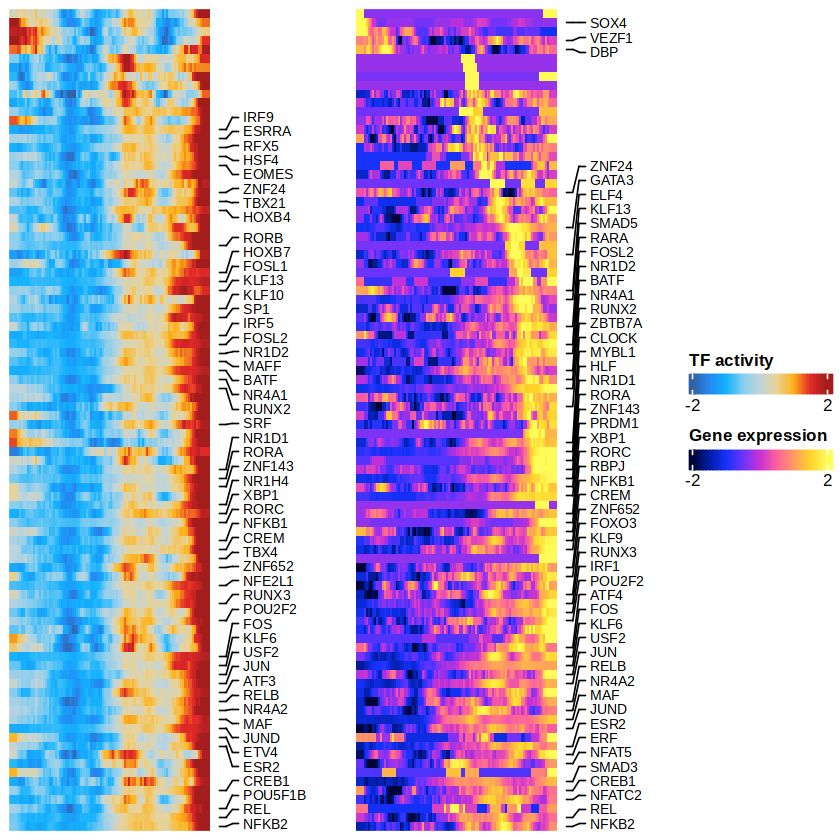

In [70]:
df.cor <- sel.tfs$tfs
ht <- sel.tfs$heatmap

draw(ht)
#ggsave(filename='plot8.png',plot=ht,width=16,height=16,dpi=600)

In [89]:
pdf("plot_output1.pdf")
ht
dev.off()

png 
  2

##  select gene

In [71]:

 sel.genes <- SelectGenes(object = pbmc.t.cells,
                  labelTop1 = 0,
                  labelTop2 = 0)


Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Linking cis-regulatory elements to genes...



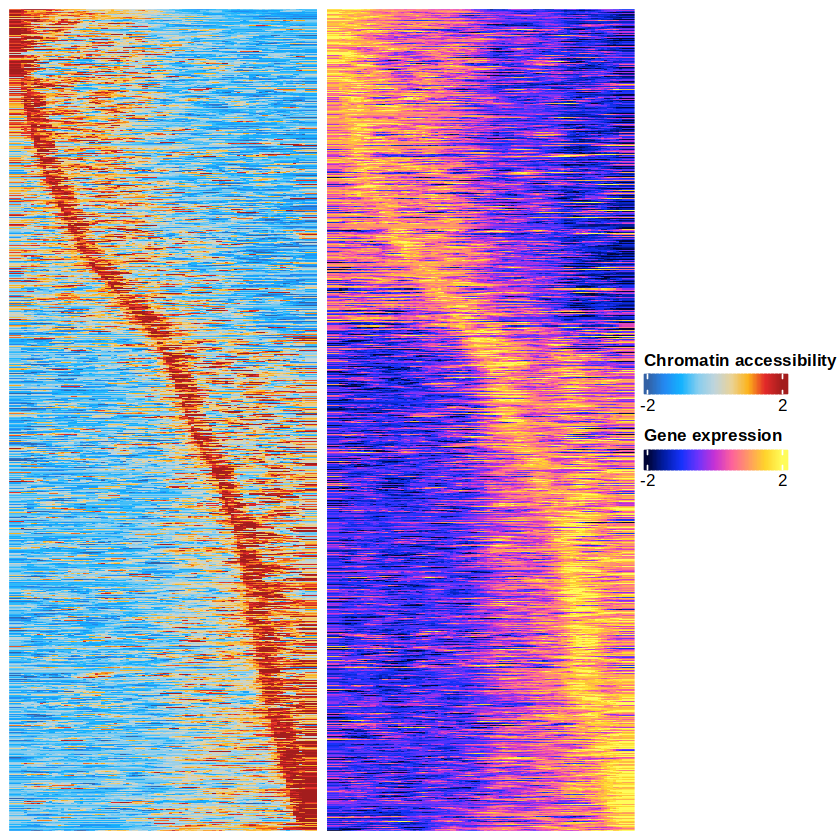

In [74]:
df.p2g <- sel.genes$p2g
ht <- sel.genes$heatmap

draw(ht)
#ggsave(filename='plot9.png',plot=ht,width=16,height=16,dpi=600)

In [94]:
pdf("plot_output2.pdf")
ht
dev.off()

png 
  2

# Gene regulatory network inference and visualization

In [95]:
###Here, we will attempt to predict gene regulatory networks based on the correlation between TF binding activity estimated from snATAC-seq and gene expression measured along the trajectory by snRNA-seq

In [75]:
tf.gene.cor <- GetTFGeneCorrelation(object = pbmc.t.cells, 
                                    tf.use = df.cor$tfs, 
                                    gene.use = unique(df.p2g$gene),
                                    tf.assay = "chromvar", 
                                    gene.assay = "RNA",
                                    trajectory.name = "Trajectory")



Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...



In [76]:
tf.gene.cor 

tf,gene,correlation,t_stat,p_value,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SOX4,SELL,0.0488446,0.4841147,6.293846e-01,6.470034e-01
VEZF1,SELL,0.1569140,1.5728537,1.189758e-01,1.311040e-01
TCF4,SELL,0.2868030,2.9637115,3.815707e-03,4.673804e-03
ELF4,SELL,-0.5981293,-7.3885470,4.990640e-11,1.048035e-10
HOXC8,SELL,-0.7230891,-10.3628921,1.976467e-17,7.556173e-17
NKX6-2,SELL,-0.6690687,-8.9120511,2.772909e-14,7.727841e-14
CEBPG,SELL,-0.1750822,-1.7604174,8.145688e-02,9.095523e-02
KLF13,SELL,-0.9136677,-22.2526376,4.241496e-40,3.021892e-38
RORC,SELL,-0.8638605,-16.9768837,6.064347e-31,1.201427e-29


tf.gene.cor <- GetTFGeneCorrelation(object = pbmc.t.cells, 
                                    tf.use = df.cor$tfs, 
                                    gene.use = unique(df.p2g$gene),
                                    tf.assay = "chromvar", 
                                    gene.assay = "RNA",
                                    trajectory.name = "Trajectory")

In [97]:
###We can then visualize this correlation matrix via a heatmap. Furthermore, we can cluster genes and TFs to identify distinct regulatory modules for predefined subpopulations.

In [77]:
ht <- GRNHeatmap(tf.gene.cor, 
                 tf.timepoint = df.cor$time_point)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



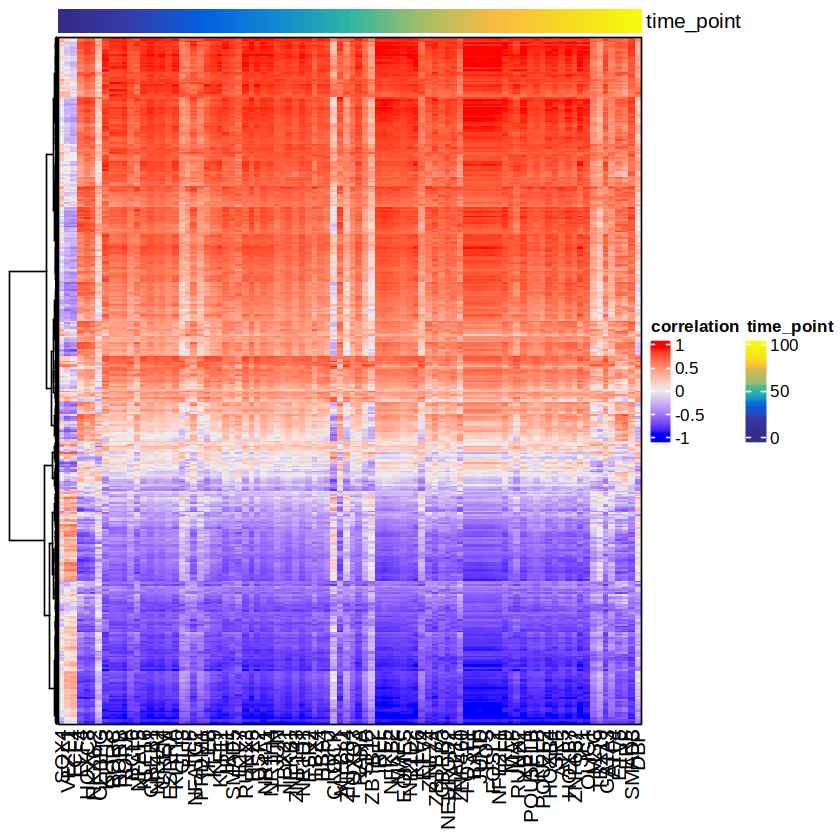

In [78]:
ht

In [100]:
#ggsave(filename='plot10.png',plot=ht,dpi=1200)

In [101]:
pdf("plot_output3.pdf")
ht
dev.off()

png 
  2

In [102]:
###To associate genes with TFs, we use the association between peaks and genes and the TF binding site information. Specifically, if a gene is regulated by a peak and the peak binds to a TF, we consider the gene to be a target of the TF.

In [79]:
motif.matching <- pbmc.t.cells@assays$ATAC@motifs@data
colnames(motif.matching) <- pbmc.t.cells@assays$ATAC@motifs@motif.names
motif.matching <-
    motif.matching[unique(df.p2g$peak), unique(tf.gene.cor$tf)]


df.grn <- GetGRN(motif.matching = motif.matching, 
                 df.cor = tf.gene.cor, 
                 df.p2g = df.p2g)

Filtering network by peak-to-gene links...

Filtering network by TF binding site prediction...



In [80]:
motif.matching

  [[ suppressing 32 column names 'SOX4', 'VEZF1', 'TCF4' ... ]]

  [[ suppressing 32 column names 'SOX4', 'VEZF1', 'TCF4' ... ]]

  [[ suppressing 32 column names 'SOX4', 'VEZF1', 'TCF4' ... ]]



14069 x 92 sparse Matrix of class "lgCMatrix"
                                                                                        
chr1-1162345-1163597     | | . . . . . . . . . . . | . . . . . | . . . . | | . . . . . .
chr1-1221728-1223045     . . . . . . . . . . . . . . . . . . | . . . . | | | | . . . . |
chr1-1165365-1172585     | | | | . . . . . | | . | | | | | | | | . | | | | | | . . . . .
chr1-1210271-1220028     . | | . . . . | . . . | . | | | | | | | . . . . | | | . | | | |
chr1-1202681-1209670     . | | . . . . | | | . . . | . . . . | | . | | . | | | . . | . |
chr1-1197018-1201988     | | | . . . . . . | | | . | . | . . | | . . . . | | . . . . . |
chr1-1175114-1175707     . . | | . . . | . . . . . | . . . . . . . . . . | . | . | . . .
chr1-965294-968061       . | | . . . . . . . . . . | . . . . | | . . | . | | | . . . . |
chr1-1181646-1184172     . . | . . . . | . . . . . | . | . . | | . | | . | | . . . . . .
chr1-1173115-1174478     . . . . . . . . . . . . . | . . . . | |

Warning message:
"Using alpha for a discrete variable is not advised."


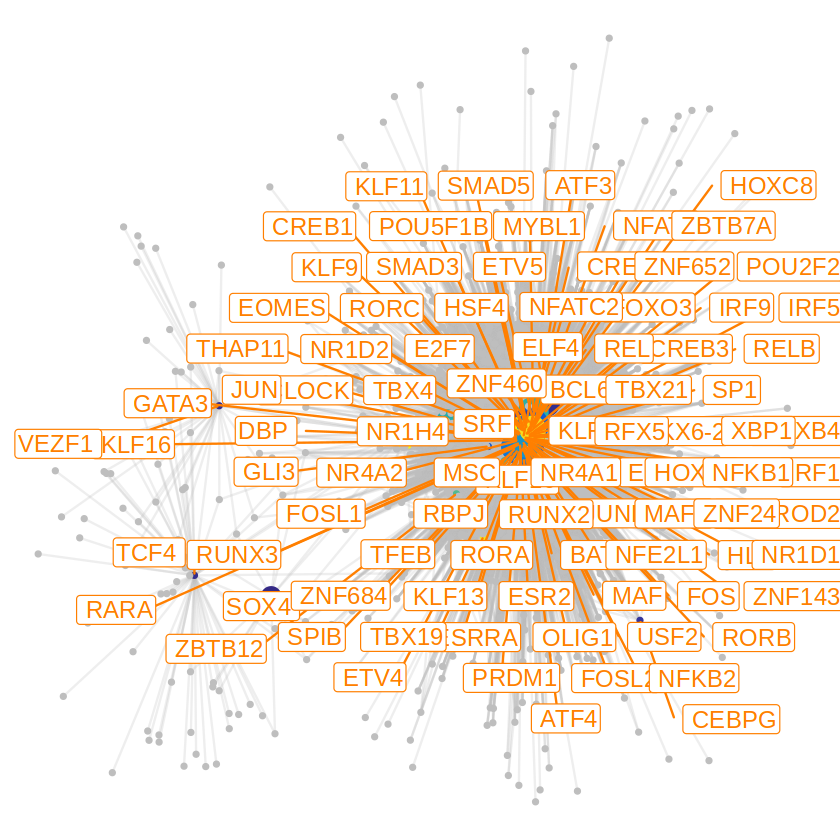

In [81]:
# define colors for nodes representing TFs (i.e., regulators)
df.cor <- df.cor[order(df.cor$time_point), ]
tfs.timepoint <- df.cor$time_point
names(tfs.timepoint) <- df.cor$tfs

# plot the graph, here we can highlight some genes
df.grn2 <- df.grn %>%
    subset(correlation > 0.5) %>%
    select(c(tf, gene, correlation)) %>%
    rename(weights = correlation)

p <- GRNPlot(df.grn2, 
             tfs.timepoint = tfs.timepoint,
             show.tf.labels = TRUE,
             seed = 42, 
             plot.importance = FALSE,
            min.importance = 2,
            remove.isolated = FALSE)

print(p)
#ggsave(filename='plot11.png',plot=p,width=16,height=16,dpi=600)

In [89]:
df.grn2

,tf,gene,weights
,<chr>,<chr>,<dbl>
1,ATF3,A2M,0.5790885
4,ATF3,ABR,0.6090864
5,ATF3,ACOT9,0.8132736
6,ATF3,ACTN4,0.7665798
7,ATF3,ACTR2,0.6569921
9,ATF3,ADAM17,0.6752731
10,ATF3,ADAM19,0.8448767
11,ATF3,ADAM8,0.6573535
13,ATF3,ADCY9,0.7329459


In [93]:
 sox4<-df.grn2[df.grn2['tf'] == 'SOX4',]
sox4

,tf,gene,weights
,<chr>,<chr>,<dbl>
89266,SOX4,CAMK1D,0.5937399
89410,SOX4,DBP,0.5219655
89610,SOX4,GZMM,0.5871849
89616,SOX4,HEG1,0.6054455
89782,SOX4,LGALS3BP,0.6573548
89838,SOX4,MAN2A1,0.5027112
89859,SOX4,MCTP2,0.6160424
89953,SOX4,NRIP1,0.5209061
89967,SOX4,OSBPL5,0.6207809


In [97]:
df.grn2[df.grn2['tf'] == 'TCF4']

[1] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
  [7] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [13] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [19] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [25] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [31] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [37] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [43] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [49] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [55] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [61] "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"      "TCF4"     
 [67] "ADAMTS10"  "AKAP7"     "ANAPC16"   "AOAH"      "ARHGAP32"  "BNIP3"    
 [73] "CACHD1"    "CAMK1D"    "CBX4"      "CCT5"      "CDCA7L"    "CENPP"    
 [79] "CHMP7"     "COL18A1"   "DBP"       "DGKA"      "DGKD"      "FLNB"     
 [85] "GZMM"      "HEG1"      "HIPK2"     "HKDC1"     "IFT88"     "ITGA6"    
 [91] "ITPRIP"    "LGALS3BP"  "LY86"      "LY9"       "MAN2A1"    "MARCKSL1" 
 [97] "MCTP2"     "MICU3"     "MTFR1"     "NCF1"      "NDUFAF3"   "NIN"      
[103] "NME7"      "NMT2"      "NONO"      "NUCB2"     "OSBPL5"    "PECAM1"   
[109] "PELI2"     "PITPNC1"   "PLXDC1"    "POLR2J3"   "PTK2"      "PXYLP1"   
[115] "PYCR2"     "RBM23"     "RFTN1"     "RHOH"      "RREB1"     "SLC16A10" 
[121] "SNRK"      "SPCS1"     "SSBP2"     "STMN1"     "SUSD3"     "TENM1"    
[127] "TMEM263"   "TMOD2"     "TNFRSF10A" "TNFRSF10D" "TTC28"     "YLPM1"    
[133] "0.5286486" "0.5812356" "0.6150016" "0.5565392" "0.5436359" "0.5397818"
[139] "0.6651562" "0.7179462" "0.5486382" "0.5318219" "0.5386740" "0.5490881"
[145] "0.5563293" "0.5115590" "0.6457405" "0.5242460" "0.5345075" "0.5350742"
[151] "0.7836839" "0.5542831" "0.6155279" "0.5758405" "0.6409785" "0.5510442"
[157] "0.6277071" "0.7571263" "0.5053716" "0.5068899" "0.6028841" "0.5508749"
[163] "0.5487430" "0.5054955" "0.5605522" "0.5312205" "0.6116081" "0.5001914"
[169] "0.7338504" "0.5478521" "0.5503241" "0.5530843" "0.6578246" "0.7094164"
[175] "0.6295149" "0.5242986" "0.6018221" "0.5941935" "0.6488762" "0.5141197"
[181] "0.5163350" "0.6501248" "0.5120339" "0.5055592" "0.5699996" "0.5388579"
[187] "0.6609543" "0.5086638" "0.6382448" "0.5804254" "0.5592045" "0.5212213"
[193] "0.5241363" "0.6138074" "0.5085664" "0.5803059" "0.5906718" "0.6163847"

# GRN Visulation

In [111]:
pbmc.t.cells <- AddTargetAssay(object = pbmc.t.cells, df.grn = df.grn2)

p1 <- PseudotimePlot(object = pbmc.t.cells, tf.use = "SOX4")

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...



In [112]:
p2 <- PseudotimePlot(object = pbmc.t.cells, tf.use = "TCF4")

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


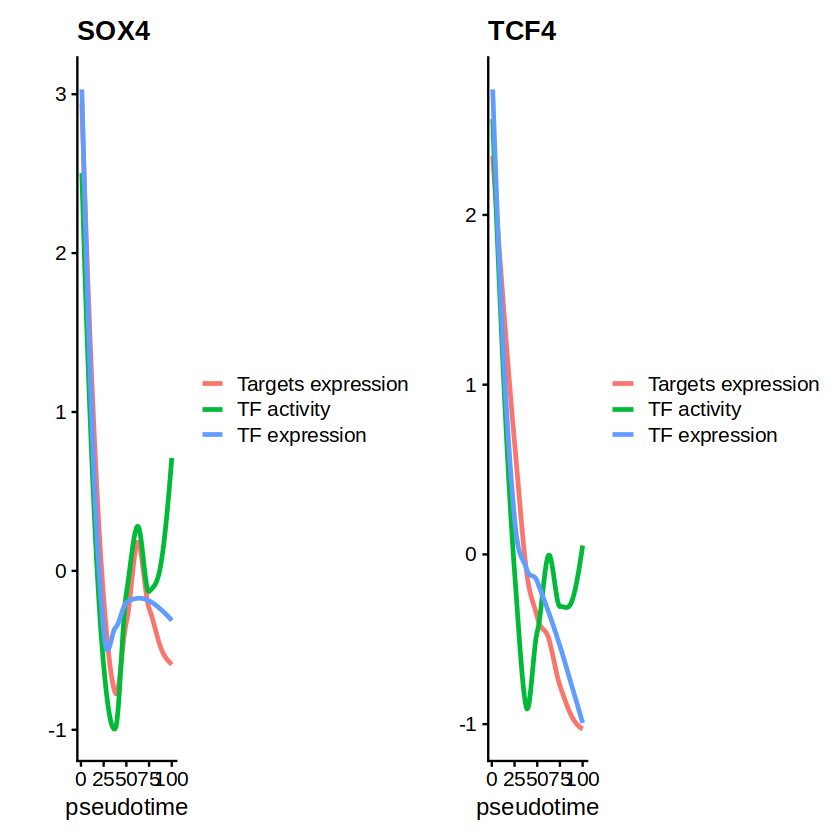

In [113]:
p1 + p2
ggsave(filename='plot12.png',plot=p1+p2,width=16,height=8,dpi=600)

In [115]:
mem_used()

16.1 GB